In [40]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

In [41]:
# Paths
train_path = r'C:\Users\RISHI PANDE\Documents\Prediction\train_Nails'
csv_path = r'C:\Users\RISHI PANDE\Documents\Prediction\Extracted_RGB.CSV'

In [42]:
# Classes
classes = ['Bluish nail', 'Healthy', 'Splinter Hemmorrage', 'White Nail', 'Yellow Nail']

In [43]:

# Initialize list to hold data
data = []

In [44]:
# Loop through each class directory
for disease in classes:
    disease_path = os.path.join(train_path, disease)
    for img_name in os.listdir(disease_path):
        img_path = os.path.join(disease_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            mean_rgb = img.mean(axis=(0, 1))
            red_value = mean_rgb[2]
            green_value = mean_rgb[1]
            blue_value = mean_rgb[0]
            mean_value = mean_rgb.mean()
            data.append([img_path, red_value, green_value, blue_value, mean_value, disease])

In [45]:
# Create DataFrame
df = pd.DataFrame(data, columns=['Image_Path', 'Red Pixel Value', 'Green Pixel Value', 'Blue Pixel Value', 'Mean RGB Pixel', 'Detected Disease'])

In [46]:
# Shuffle the dataset
df = shuffle(df)

In [47]:
# Encode labels and convert to string
df['Encoded_Labels'] = df['Detected Disease'].astype('category').cat.codes.astype(str)

In [48]:
# Save to CSV
df.to_csv(csv_path, index=False)

In [49]:
# Display the head of the CSV file
print(df.head())

                                             Image_Path  Red Pixel Value  \
409   C:\Users\RISHI PANDE\Documents\Prediction\trai...       174.249107   
861   C:\Users\RISHI PANDE\Documents\Prediction\trai...       181.240612   
2247  C:\Users\RISHI PANDE\Documents\Prediction\trai...       204.491462   
2021  C:\Users\RISHI PANDE\Documents\Prediction\trai...       146.921062   
1398  C:\Users\RISHI PANDE\Documents\Prediction\trai...       211.542172   

      Green Pixel Value  Blue Pixel Value  Mean RGB Pixel  \
409          156.248862        194.251895      174.916621   
861          140.702974        124.685302      148.876296   
2247         166.923474        157.041075      176.152004   
2021         128.871502        120.575201      132.122589   
1398         190.409270        174.684536      192.211993   

         Detected Disease Encoded_Labels  
409               Healthy              1  
861   Splinter Hemmorrage              2  
2247          Yellow Nail              4  
2021

In [55]:
import pandas as pd

In [56]:
# Load the CSV file
csv_path = r'C:\Users\RISHI PANDE\Documents\Prediction\Extracted_RGB.CSV'
df = pd.read_csv(csv_path)

In [57]:
# Convert Encoded_Labels to string
df['Encoded_Labels'] = df['Encoded_Labels'].astype(str)

In [58]:
# Check the column types
print(df.dtypes)

Image_Path            object
Red Pixel Value      float64
Green Pixel Value    float64
Blue Pixel Value     float64
Mean RGB Pixel       float64
Detected Disease      object
Encoded_Labels        object
dtype: object


In [59]:
# Print the DataFrame structure and sample values
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Path         2820 non-null   object 
 1   Red Pixel Value    2820 non-null   float64
 2   Green Pixel Value  2820 non-null   float64
 3   Blue Pixel Value   2820 non-null   float64
 4   Mean RGB Pixel     2820 non-null   float64
 5   Detected Disease   2820 non-null   object 
 6   Encoded_Labels     2820 non-null   object 
dtypes: float64(4), object(3)
memory usage: 154.3+ KB
None
                                          Image_Path  Red Pixel Value  \
0  C:\Users\RISHI PANDE\Documents\Prediction\trai...       174.249107   
1  C:\Users\RISHI PANDE\Documents\Prediction\trai...       181.240612   
2  C:\Users\RISHI PANDE\Documents\Prediction\trai...       204.491462   
3  C:\Users\RISHI PANDE\Documents\Prediction\trai...       146.921062   
4  C:\Users\RISHI PANDE\Documents\Pred

In [60]:
# Check for empty or NaN values
print(df.isna().sum())

Image_Path           0
Red Pixel Value      0
Green Pixel Value    0
Blue Pixel Value     0
Mean RGB Pixel       0
Detected Disease     0
Encoded_Labels       0
dtype: int64


In [61]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [62]:
# Load the CSV file
csv_path = r'C:\Users\RISHI PANDE\Documents\Prediction\Extracted_RGB.CSV'
df = pd.read_csv(csv_path)

In [63]:
# Convert Encoded_Labels to string
df['Encoded_Labels'] = df['Encoded_Labels'].astype(str)

In [64]:
# Image dimensions
img_size = (224, 224)

In [65]:
# Create ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [66]:
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image_Path',
    y_col='Encoded_Labels',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image_Path',
    y_col='Encoded_Labels',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2256 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


In [67]:
# Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [68]:
# Freeze base model
base_model.trainable = False


In [69]:
# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(df['Encoded_Labels'].unique()), activation='softmax')(x)


In [70]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [72]:
# Compile the model with corrected learning rate argument
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


c:\Users\RISHI PANDE\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.2789 - loss: 1.7702 - val_accuracy: 0.6028 - val_loss: 1.2309
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.4531 - loss: 1.3005 - val_accuracy: 0.5656 - val_loss: 1.0722
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.5683 - loss: 1.0906 - val_accuracy: 0.6649 - val_loss: 0.8987
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.6402 - loss: 0.9305 - val_accuracy: 0.7340 - val_loss: 0.7751
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.6790 - loss: 0.8268 - val_accuracy: 0.7589 - val_loss: 0.6812
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.7358 - loss: 0.7141 - val_accuracy: 0.7500 - val_loss: 0.6736
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.7487 - loss: 0.6513 - val_accuracy: 0.7465 - val_loss: 0.6454
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.7901 - loss: 0.6091 - val_accuracy: 0.7890 - val_loss: 0.

In [74]:
# Save the model
model.save(r'C:\Users\RISHI PANDE\Documents\Prediction\nail_disease_model.h5')

In [77]:
# Load the saved model
model = load_model(model_path)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8037 - loss: 0.5205
Validation Accuracy: 78.90%


In [78]:
# Predict the labels for validation data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step


In [79]:
# Get the true labels
y_true = validation_generator.classes

In [80]:
# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

In [81]:
# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

           0       0.11      0.07      0.08        44
           1       0.08      0.09      0.09        78
           2       0.22      0.14      0.17       133
           3       0.32      0.45      0.37       173
           4       0.17      0.16      0.17       136

    accuracy                           0.23       564
   macro avg       0.18      0.18      0.18       564
weighted avg       0.21      0.23      0.21       564



In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

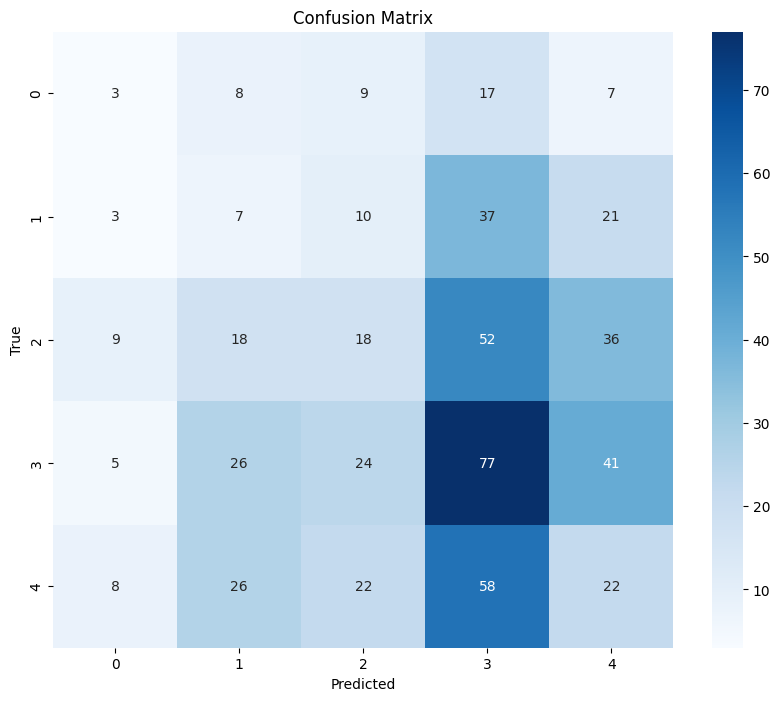

In [84]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()